In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


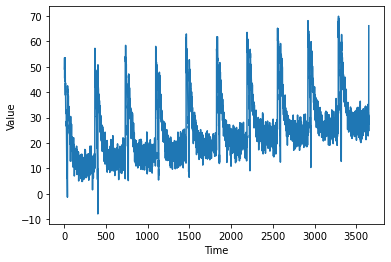

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 7s 8ms/step - loss: 17.9235 - mae: 18.4235
Epoch 2/100
94/94 [==============================] - 1s 8ms/step - loss: 18.1005 - mae: 18.6005
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 17.9976 - mae: 18.4976
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 17.8102 - mae: 18.3102
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 17.9366 - mae: 18.4366
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 17.7680 - mae: 18.2680
Epoch 7/100
94/94 [==============================] - 1s 8ms/step - loss: 17.8528 - mae: 18.3528
Epoch 8/100
94/94 [==============================] - 1s 9ms/step - loss: 17.6084 - mae: 18.1084
Epoch 9/100
94/94 [==============================] - 1s 8ms/step - loss: 17.7662 - mae: 18.2662
Epoch 10/100
94/94 [==============================] - 1s 8ms/step - loss: 17.5260 - mae: 18.0260
Epoch 11/100
94/94 [===================

94/94 [==============================] - 1s 8ms/step - loss: 2.9167 - mae: 3.3793
Epoch 87/100
94/94 [==============================] - 1s 8ms/step - loss: 3.0211 - mae: 3.4860
Epoch 88/100
94/94 [==============================] - 1s 8ms/step - loss: 2.8025 - mae: 3.2631
Epoch 89/100
94/94 [==============================] - 1s 8ms/step - loss: 2.9860 - mae: 3.4529
Epoch 90/100
94/94 [==============================] - 1s 8ms/step - loss: 3.0280 - mae: 3.4943
Epoch 91/100
94/94 [==============================] - 1s 8ms/step - loss: 2.7891 - mae: 3.2514
Epoch 92/100
94/94 [==============================] - 1s 8ms/step - loss: 3.1728 - mae: 3.6412
Epoch 93/100
94/94 [==============================] - 1s 8ms/step - loss: 2.8007 - mae: 3.2582
Epoch 94/100
94/94 [==============================] - 1s 8ms/step - loss: 2.7083 - mae: 3.1694
Epoch 95/100
94/94 [==============================] - 1s 8ms/step - loss: 3.0647 - mae: 3.5273
Epoch 96/100
94/94 [==============================] - 1s 8ms/st

(1e-08, 0.0001, 0.0, 30.0)

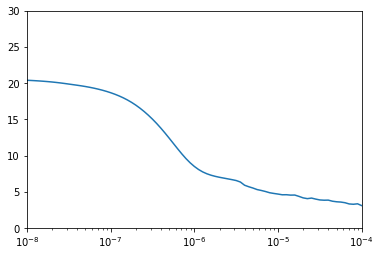

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 6s 8ms/step - loss: 621.4114 - mae: 17.3184
Epoch 2/500
94/94 [==============================] - 1s 8ms/step - loss: 35.4448 - mae: 3.9949
Epoch 3/500
94/94 [==============================] - 1s 7ms/step - loss: 24.7060 - mae: 3.3967
Epoch 4/500
94/94 [==============================] - 1s 7ms/step - loss: 27.9482 - mae: 3.7105
Epoch 5/500
94/94 [==============================] - 1s 8ms/step - loss: 25.3553 - mae: 3.5254
Epoch 6/500
94/94 [==============================] - 1s 8ms/step - loss: 23.1941 - mae: 3.3501
Epoch 7/500
94/94 [==============================] - 1s 8ms/step - loss: 29.9593 - mae: 3.9666
Epoch 8/500
94/94 [==============================] - 1s 8ms/step - loss: 27.3687 - mae: 3.7184
Epoch 9/500
94/94 [==============================] - 1s 7ms/step - loss: 22.7929 - mae: 3.4158
Epoch 10/500
94/94 [==============================] - 1s 7ms/step - loss: 24.3467 - mae: 3.4988
Epoch 11/500
94/94 [===========================

94/94 [==============================] - 1s 8ms/step - loss: 19.5550 - mae: 3.0909
Epoch 87/500
94/94 [==============================] - 1s 8ms/step - loss: 23.7012 - mae: 3.3429
Epoch 88/500
94/94 [==============================] - 1s 8ms/step - loss: 19.6335 - mae: 3.0113
Epoch 89/500
94/94 [==============================] - 1s 8ms/step - loss: 20.6737 - mae: 3.1397
Epoch 90/500
94/94 [==============================] - 1s 8ms/step - loss: 21.0678 - mae: 3.2109
Epoch 91/500
94/94 [==============================] - 1s 8ms/step - loss: 19.2577 - mae: 3.0604
Epoch 92/500
94/94 [==============================] - 1s 8ms/step - loss: 24.6516 - mae: 3.3844
Epoch 93/500
94/94 [==============================] - 1s 8ms/step - loss: 19.4174 - mae: 3.0956
Epoch 94/500
94/94 [==============================] - 1s 8ms/step - loss: 22.5119 - mae: 3.2385
Epoch 95/500
94/94 [==============================] - 1s 8ms/step - loss: 20.3042 - mae: 3.1460
Epoch 96/500
94/94 [==============================] -

94/94 [==============================] - 1s 7ms/step - loss: 18.9149 - mae: 2.9938
Epoch 171/500
94/94 [==============================] - 1s 8ms/step - loss: 18.7565 - mae: 3.0190
Epoch 172/500
94/94 [==============================] - 1s 7ms/step - loss: 18.1085 - mae: 2.9047
Epoch 173/500
94/94 [==============================] - 1s 7ms/step - loss: 21.5411 - mae: 3.0996
Epoch 174/500
94/94 [==============================] - 1s 7ms/step - loss: 18.2533 - mae: 2.9807
Epoch 175/500
94/94 [==============================] - 1s 7ms/step - loss: 19.4537 - mae: 3.0519
Epoch 176/500
94/94 [==============================] - 1s 7ms/step - loss: 20.2369 - mae: 3.1429
Epoch 177/500
94/94 [==============================] - 1s 7ms/step - loss: 20.0292 - mae: 2.9416
Epoch 178/500
94/94 [==============================] - 1s 7ms/step - loss: 22.2216 - mae: 3.2147
Epoch 179/500
94/94 [==============================] - 1s 7ms/step - loss: 16.3235 - mae: 2.8962
Epoch 180/500
94/94 [=======================

94/94 [==============================] - 1s 7ms/step - loss: 18.2043 - mae: 3.0000
Epoch 255/500
94/94 [==============================] - 1s 8ms/step - loss: 20.1470 - mae: 3.0553
Epoch 256/500
94/94 [==============================] - 1s 8ms/step - loss: 20.1962 - mae: 3.0690
Epoch 257/500
94/94 [==============================] - 1s 7ms/step - loss: 18.5919 - mae: 3.0311
Epoch 258/500
94/94 [==============================] - 1s 7ms/step - loss: 20.1400 - mae: 2.9516
Epoch 259/500
94/94 [==============================] - 1s 7ms/step - loss: 21.0557 - mae: 3.2473
Epoch 260/500
94/94 [==============================] - 1s 7ms/step - loss: 21.9959 - mae: 3.1393
Epoch 261/500
94/94 [==============================] - 1s 8ms/step - loss: 19.6906 - mae: 2.9853
Epoch 262/500
94/94 [==============================] - 1s 7ms/step - loss: 22.0210 - mae: 3.1863
Epoch 263/500
94/94 [==============================] - 1s 7ms/step - loss: 15.7327 - mae: 2.8185
Epoch 264/500
94/94 [=======================

94/94 [==============================] - 1s 7ms/step - loss: 20.4768 - mae: 2.9107
Epoch 339/500
94/94 [==============================] - 1s 7ms/step - loss: 18.4572 - mae: 2.8911
Epoch 340/500
94/94 [==============================] - 1s 7ms/step - loss: 23.5514 - mae: 3.1162
Epoch 341/500
94/94 [==============================] - 1s 7ms/step - loss: 19.9026 - mae: 2.9385
Epoch 342/500
94/94 [==============================] - 1s 7ms/step - loss: 19.4348 - mae: 2.9921: 0s - los
Epoch 343/500
94/94 [==============================] - 1s 8ms/step - loss: 19.3987 - mae: 3.0215
Epoch 344/500
94/94 [==============================] - 1s 7ms/step - loss: 19.8050 - mae: 2.9879
Epoch 345/500
94/94 [==============================] - 1s 7ms/step - loss: 22.2969 - mae: 3.0994
Epoch 346/500
94/94 [==============================] - 1s 7ms/step - loss: 21.3167 - mae: 3.1108
Epoch 347/500
94/94 [==============================] - 1s 7ms/step - loss: 19.1513 - mae: 3.0479
Epoch 348/500
94/94 [=============

94/94 [==============================] - 1s 8ms/step - loss: 18.6792 - mae: 2.9514
Epoch 423/500
94/94 [==============================] - 1s 8ms/step - loss: 17.9033 - mae: 2.9799
Epoch 424/500
94/94 [==============================] - 1s 8ms/step - loss: 17.2352 - mae: 2.9694
Epoch 425/500
94/94 [==============================] - 1s 8ms/step - loss: 20.8151 - mae: 3.0248
Epoch 426/500
94/94 [==============================] - 1s 8ms/step - loss: 16.1940 - mae: 2.7657
Epoch 427/500
94/94 [==============================] - 1s 8ms/step - loss: 18.1045 - mae: 2.9535
Epoch 428/500
94/94 [==============================] - 1s 8ms/step - loss: 20.9750 - mae: 3.0301
Epoch 429/500
94/94 [==============================] - 1s 8ms/step - loss: 19.8286 - mae: 2.8803
Epoch 430/500
94/94 [==============================] - 1s 8ms/step - loss: 18.5292 - mae: 2.9686
Epoch 431/500
94/94 [==============================] - 1s 8ms/step - loss: 21.6948 - mae: 3.0778
Epoch 432/500
94/94 [=======================

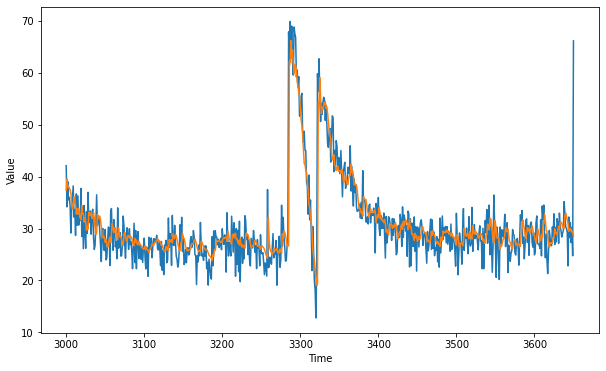

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9205346

<Figure size 432x288 with 0 Axes>

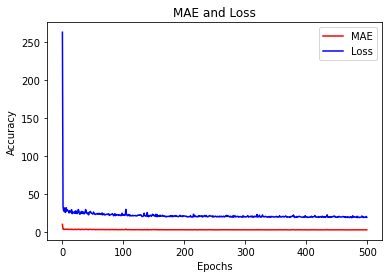

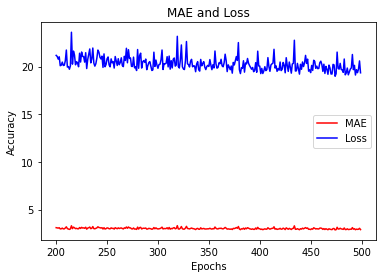

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()